<a href="https://colab.research.google.com/github/OllyMuh/ML_algorythms/blob/main/Gradient%20Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ 6. Градиентный бустинг. AdaBoost

In [ ]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [ ]:
from sklearn.datasets import load_diabetes

Используем один из «игрушечных» датасетов из той же библиотеки.

In [ ]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [ ]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже считаются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [ ]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ её производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем её также в виде функции — коэффициент 2 можно отбросить.

In [ ]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [ ]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

## Практическое задание

**1. Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров.**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [ ]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Построим график зависимости ошибки на обучающей и тестовой выборках от числа деревьев.

In [ ]:
train_errors = []
test_errors = []

for n_trees in range(1, 20):
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))

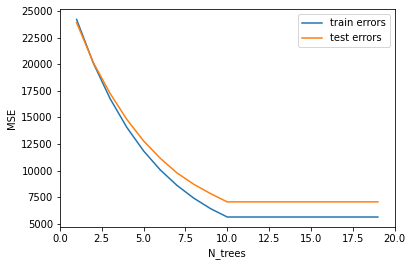

In [ ]:
x = list(range(1, 20))

plt.xlim(0, 20)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N_trees')
plt.ylabel('MSE')
plt.legend(loc='upper right');

Построим график зависимости ошибки на обучающей и тестовой выборках от максимальной глубины дерева.

In [ ]:
train_errors = []
test_errors = []

for max_depth in range(1, 25):
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))

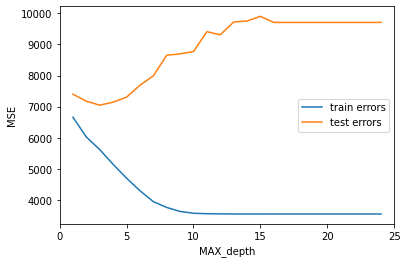

In [ ]:
x = list(range(1, 25))

plt.xlim(0, 25)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('MAX_depth')
plt.ylabel('MSE')
plt.legend(loc='center right');

Вывод: 

1. При увеличении количества деревьев ошибка уменьшается. Модель немного переобучается при достижении оптимального количества деревьев, но после этого ошибка уже не растет, т.к. деревьям уже нечего друг за другом исправлять.

2. При увеличении глубины деревьев модель сильно переобучается. Оптимально использовать ГБ при незначительной максимальной глубине.

**2. Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.**

In [ ]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, rand_sample_size=0.5):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Рандомный выбор индексов в установленном рандомном размере
            all_ind = list(range(X_train.shape[0]))
            train_ind = np.random.choice(all_ind, size=int(rand_sample_size*len(all_ind)))
            
            # Получим ответы на текущей выбранной композиции
            target = gb_predict(X_train[train_ind], trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг, но не полный, а только части выборки
            tree.fit(X_train[train_ind], bias(y_train[train_ind], target))
            
            train_errors.append(mean_squared_error(y_train[train_ind], gb_predict(X_train[train_ind], trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors


# def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
#     # Деревья будем записывать в список
#     trees = []
    
#     # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
#     train_errors = []
#     test_errors = []
    
#     for i in range(n_trees):
#         tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

#         # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
#         # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
#         if len(trees) == 0:
#             # обучаем первое дерево на обучающей выборке
#             tree.fit(X_train, y_train)
            
#             train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
#             test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
#         else:
#             # Получим ответы на текущей композиции
#             target = gb_predict(X_train, trees, coefs, eta)
            
#             # алгоритмы начиная со второго обучаем на сдвиг
#             tree.fit(X_train, bias(y_train, target))
            
#             train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
#             test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

#         trees.append(tree)
        
#     return trees, train_errors, test_errors

In [ ]:
n_trees = 10
coefs = [1] * n_trees
max_depth = 3
eta = 0.5

trees, train_errors_s, test_errors_s = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [ ]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

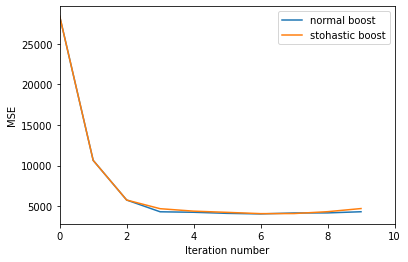

In [ ]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), test_errors, label='normal boost')
plt.plot(list(range(n_trees)), test_errors_s, label='stohastic boost')
plt.legend(loc='upper right')
plt.show();